In [28]:
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

#### Merged image generation

In [36]:
def merge_leaf_to_cucumber(cucumber_image, leaf_image, cucumber_bbox, leaf_bbox, offset_y=0):
    # 오이 객체 중심 계산
    cuc_center_x = (cucumber_bbox[0] + cucumber_bbox[2]) // 2
    cuc_center_y = (cucumber_bbox[1] + cucumber_bbox[3]) // 2
    
    # 잎 이미지의 크기와 위치 계산
    leaf_h, leaf_w = leaf_image.shape[:2]
    leaf_x = cuc_center_x - leaf_w // 2
    leaf_y = cuc_center_y + offset_y - leaf_h // 2

    # 이미지 병합 (투명 배경 유지)
    result_image = cucumber_image.copy()

    # 잎에 대한 segmentation mask 생성 (0으로 채운 마스크를 생성하고, 잎이 있는 부분만 255로 설정)
    leaf_mask = np.zeros((cucumber_image.shape[0], cucumber_image.shape[1]), dtype=np.uint8)

    for i in range(leaf_h):
        for j in range(leaf_w):
            # 잎 이미지의 알파 채널을 고려하여 합성
            if leaf_image[i, j, 3] > 0:  # 알파 채널이 0보다 크면 (투명하지 않다면)
                result_image[leaf_y + i, leaf_x + j] = leaf_image[i, j, :3]  # RGB 채널만 병합
                leaf_mask[leaf_y + i, leaf_x + j] = 255  # 잎의 마스크 부분을 255로 설정

    return result_image, leaf_mask, (leaf_x, leaf_y, leaf_x + leaf_w, leaf_y + leaf_h)


def save_merged_image(cucumber_image_path, leaf_image_path, cucumber_bbox,  offset_y=0, save_dir=None):
    # 오이 이미지와 잎 이미지 로드
    cucumber_image = cv2.imread(cucumber_image_path, cv2.IMREAD_UNCHANGED)
    leaf_image = cv2.imread(leaf_image_path, cv2.IMREAD_UNCHANGED)

    # 이미지를 합성
    merged_image, leaf_mask, leaf_new_bbox = merge_leaf_to_cucumber(cucumber_image, leaf_image, cucumber_bbox,  offset_y)

    # 결과 이미지 파일 저장 경로 설정
    cucumber_image_name = os.path.basename(cucumber_image_path)
    merged_image_name = f"merged_{cucumber_image_name}"

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)  # 저장 경로가 없으면 생성
        merged_image_path = os.path.join(save_dir, merged_image_name)
    else:
        merged_image_path = cucumber_image_name  # 경로 미지정 시, 동일 디렉토리에 저장

    # 결과 이미지를 PNG 형식으로 저장 (알파 채널 포함)
    cv2.imwrite(merged_image_path, merged_image)

    print(f"합성된 이미지 저장됨: {merged_image_path}")
    
    return merged_image_path, leaf_mask, leaf_new_bbox  # 저장된 이미지 경로와 새로운 bbox 반환


##### amodal mask info (occluder, occuluded)

In [41]:
# Amodal 마스크 생성
def generate_amodal_mask(cucumber_mask, leaf_mask):
    # 겹치는 부분 (오이 마스크와 잎 마스크가 동시에 255인 부분을 추출)
    overlap_mask = (cucumber_mask == 255) & (leaf_mask == 255)
    
    # Amodal 마스크 생성 (오이와 잎을 모두 포함하는 마스크)
    amodal_mask = np.maximum(cucumber_mask, leaf_mask)
    visualize_masks(cucumber_mask, leaf_mask, amodal_mask)
    

    # Modal 마스크 생성 (겹치는 부분을 제외한 오이 마스크)
    modal_mask = cucumber_mask.copy()
    modal_mask[overlap_mask] = 0  # overlap 영역을 0으로 만들어 겹친 부분 제거

    return amodal_mask, modal_mask, overlap_mask

def save_amodal_mask(amodal_mask, image_name, save_dir):
    # Amodal 마스크 저장 경로 생성
    os.makedirs(save_dir, exist_ok=True)  # 저장 경로가 없으면 생성
    mask_filename = f"{os.path.splitext(image_name)[0]}_amodal_mask.png"
    mask_path = os.path.join(save_dir, mask_filename)

    # 마스크를 PNG 형식으로 저장 (이진화된 값 0 또는 255로 저장)
    cv2.imwrite(mask_path, amodal_mask)  # 0과 255 값을 가진 마스크를 저장
    print(f"Amodal 마스크 저장됨: {mask_path}")

    return mask_path

# Occlusion 정보 수집 및 저장
def save_amodal_info_to_json(image_name, objects_info, json_dir):
    json_data = {
        "image_name": image_name,
        "objects": []
    }
    
    for obj in objects_info:
        obj_data = {
            "id": obj["id"],
            "class": obj["class"],
            "bbox": obj["bbox"],
            "mask_path": obj["mask_path"],
            "occlusion": obj["occlusion"],
            "occluder_id": obj.get("occluder_id", None),  # 가리는 객체 ID
            "occluded_id": obj.get("occluded_id", None)   # 가려지는 객체 ID
        }
        json_data["objects"].append(obj_data)

    # JSON 파일 저장
    json_filename = os.path.splitext(image_name)[0] + "_amodal_info.json"
    json_path = os.path.join(json_dir, json_filename)

    with open(json_path, 'w') as json_file:
        json.dump(json_data, json_file, indent=4)
    
    print(f"JSON 파일 저장됨: {json_path}")



In [42]:
def process_amodal_images_and_masks(cucumber_image_path, leaf_cropped_image_path, cucumber_mask_path, label_dir, save_dir, mask_save_dir, json_dir, offset_y=0):
    # 1. 마스크 파일명을 기준으로 레이블 파일에서 cucumber_bbox 정보 로드
    cucumber_mask_name = os.path.basename(cucumber_mask_path)
    cucumber_bbox = load_bbox_from_label_file(label_dir, cucumber_mask_name)
    
    if cucumber_bbox is None:
        print(f"bbox 정보를 찾을 수 없습니다. 마스크 파일명: {cucumber_mask_name}")
        return
    
    print("오이 이미지 합성 시작...")
    # 2. 오이 이미지에 잎 이미지를 합성하고 저장
    merged_image_path, leaf_mask, leaf_new_bbox = save_merged_image(cucumber_image_path, leaf_cropped_image_path, cucumber_bbox, offset_y, save_dir)

    # 3. 오이 마스크와 잎 마스크를 불러오기
    cucumber_mask = cv2.imread(cucumber_mask_path, cv2.IMREAD_GRAYSCALE)

    print("Amodal 마스크 생성 시작...")
    # 4. Amodal 마스크 생성 및 겹치는 부분 (가림) 정보 계산
    amodal_mask, modal_mask, overlap_mask = generate_amodal_mask(cucumber_mask, leaf_mask)

    print("Amodal 정보 저장 시작...")
    # 5. Amodal 마스크를 저장
    amodal_mask_path = save_amodal_mask(amodal_mask, os.path.basename(merged_image_path), mask_save_dir)

    # 6. 객체 정보 저장 (bbox 및 occlusion 정보)
    objects_info = [
        {
            "id": 1,  # 오이 객체 ID
            "class": "cucumber",
            "bbox": cucumber_bbox,
            "mask_path": cucumber_mask_path,  # 오이 마스크 파일 경로
            "occlusion": True,  # 오이가 가려짐
            "occluder_id": 2,  # 잎에 의해 가려짐
        },
        {
            "id": 2,  # 잎 객체 ID
            "class": "leaf",
            "bbox": leaf_new_bbox,
            "mask_path": leaf_cropped_image_path,  # 잎 마스크 파일 경로
            "occlusion": False,  # 잎은 가리지 않음
        }
    ]

    # 최종적으로 합성된 이미지와 amodal 마스크 저장
    save_amodal_info_to_json(os.path.basename(merged_image_path), objects_info, json_dir)
    visualize_amodal_and_modal(cv2.imread(merged_image_path, cv2.IMREAD_UNCHANGED), cucumber_mask, modal_mask)


def load_bbox_from_label_file(label_dir, mask_file_name):
    """
    레이블 폴더에서 cucumber_bbox 정보 로드
    """
    label_file = os.path.join(label_dir, os.path.splitext(mask_file_name)[0] + ".txt")
    
    if os.path.exists(label_file):
        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                # txt 파일 형식: class_id, x_min, y_min, x_max, y_max
                class_id, x_min, y_min, x_max, y_max = map(float, line.strip().split())
                if int(class_id) == 0:  # 오이의 class_id는 0으로 가정
                    return [int(x_min), int(y_min), int(x_max), int(y_max)]
    else:
        print(f"레이블 파일을 찾을 수 없습니다: {label_file}")
        return None

오이 이미지 합성 시작...
합성된 이미지 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images/merged_oi_002_1.jpg
Amodal 마스크 생성 시작...


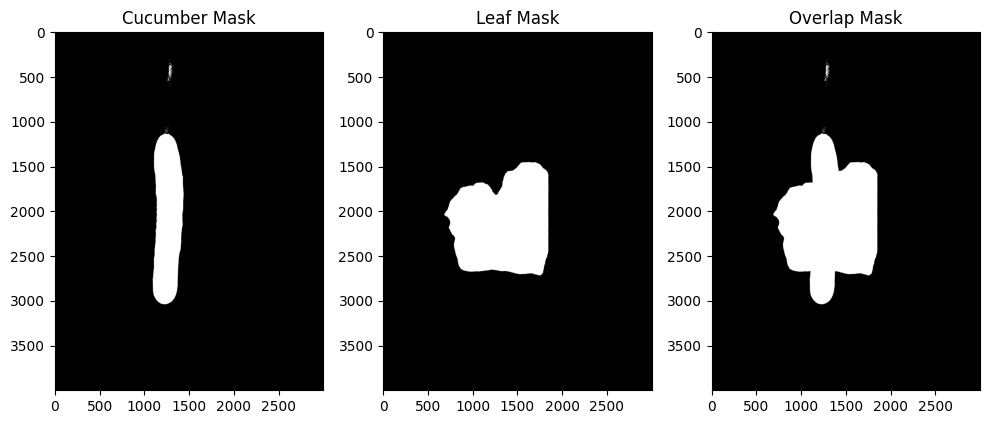

Amodal 정보 저장 시작...
Amodal 마스크 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_masks/merged_oi_002_1_amodal_mask.png
JSON 파일 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info/merged_oi_002_1_amodal_info.json


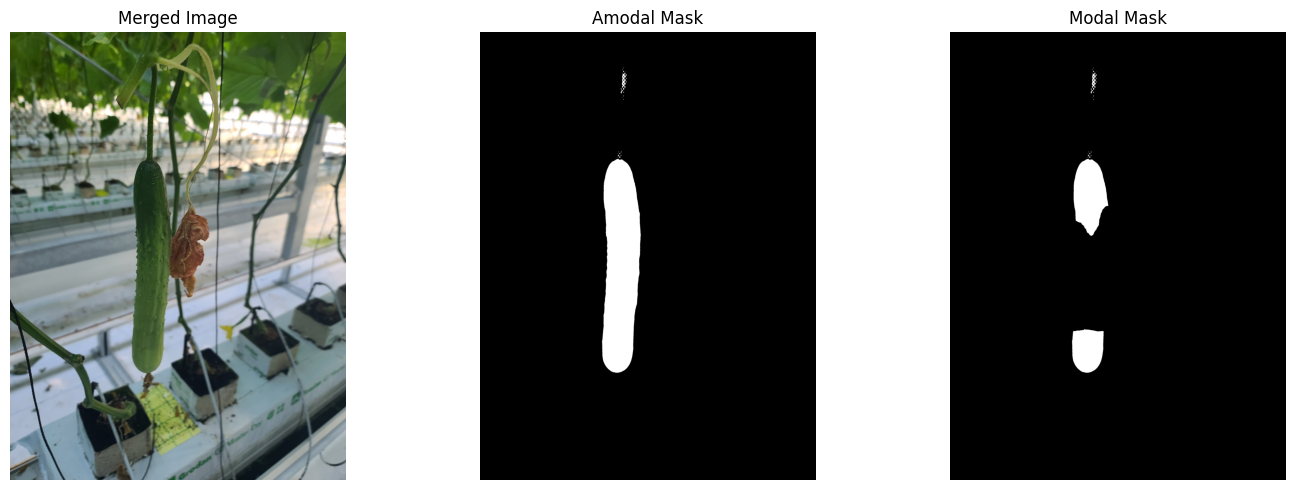

In [45]:
# 실행 예시
cucumber_image_path = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/images/oi_002_1.jpg"
leaf_cropped_image_path = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/cropped_objects/cropped_oi_029_3_1_00.png"
cucumber_mask_path = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/masks/oi_002_1_0_00.png"
label_dir = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/labels"
save_dir = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images"
mask_save_dir = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_masks"
json_dir = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info"
offset_y = 30

process_amodal_images_and_masks(cucumber_image_path, leaf_cropped_image_path, cucumber_mask_path, label_dir, save_dir, mask_save_dir, json_dir, offset_y)

In [20]:
def visualize_masks(cucumber_mask, leaf_mask, overlap_mask):
    plt.figure(figsize=(10, 5))
    
    # 오이 마스크 시각화
    plt.subplot(1, 3, 1)
    plt.imshow(cucumber_mask, cmap='gray')
    plt.title("Cucumber Mask")
    
    # 잎 마스크 시각화
    plt.subplot(1, 3, 2)
    plt.imshow(leaf_mask, cmap='gray')
    plt.title("Leaf Mask")
    
    # 겹치는 부분(overlap) 시각화
    plt.subplot(1, 3, 3)
    plt.imshow(overlap_mask, cmap='gray')
    plt.title("Overlap Mask")
    
    plt.tight_layout()
    plt.show()

In [44]:
def visualize_amodal_and_modal(merged_image, amodal_mask, modal_mask):
    """
    합성된 이미지, Amodal 마스크, Modal 마스크를 시각화하는 함수
    :param merged_image: 합성된 이미지 (RGB)
    :param amodal_mask: Amodal 마스크 (오이 전체 마스크)
    :param modal_mask: Modal 마스크 (잎에 의해 가려진 오이 마스크)
    """
    
    # Plot 설정
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))  # 1행 3열 레이아웃
    
    # 합성 이미지
    axs[0].imshow(cv2.cvtColor(merged_image, cv2.COLOR_BGR2RGB))  # BGR을 RGB로 변환
    axs[0].set_title('Merged Image')
    axs[0].axis('off')

    # Amodal 마스크
    axs[1].imshow(amodal_mask, cmap='gray')
    axs[1].set_title('Amodal Mask')
    axs[1].axis('off')

    # Modal 마스크
    axs[2].imshow(modal_mask, cmap='gray')
    axs[2].set_title('Modal Mask')
    axs[2].axis('off')

    plt.subplots_adjust(wspace=0.1)  # 가로 간격을 0.1로 줄이기
    plt.tight_layout()
    plt.show()